In [1]:
#importer
import torch, sys, os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.ticker as mtik
import numpy as np
from typing import Dict
sys.path.append(os.path.abspath(".."))
from ml_utils import parse_config, activation_decode, vizualization

### CONSTANTS

In [2]:
DATASET_TRAIN_PATH = 'data/train'
DATASET_TEST_PATH  = 'data/test'
VALID_JSON = {
    "type":"object",
    "properties":
    {
        "nn_config":
        {
            "type":"object",
            "properties":
            {
                "epochs":
                {
                    "type":"integer",
                    "minimum":10
                },
                "batch_size":
                {
                  "type":"integer",
                  "minimum":10
                },
                "act_f":
                {
                    "type":"string",
                    "enum": ["identity", "relu", "sig"]
                },
                "learning_rate":
                {
                    "type":"number",
                    "minimum": 0.0,
                    "maximum":1.0
                },
                "hidden_arr":
                {
                    "type":"array",
                    "items":
                    {
                        "type":"array",
                        "minItems":2,
                        "maxItems":2,
                        "items":
                        {
                            "type":"integer"
                        }
                    }
                }
            },
            "required":["epochs", "batch_size", "act_f", "learning_rate", "hidden_arr"]
        },
        "image":
        {
            "type":"object",
            "properties":
            {
                "w":
                {
                    "type":"integer",
                    "minimum":1
                },
                "h":
                {
                    "type":"integer",
                    "minimum":1
                },
                "path":
                {
                    "type":"string"
                }
            },
            "required":["w", "h", "path"]
        }
    },
    "required":["nn_config","image"]
}

### Prepare data for learning

In [3]:

def prepare_learn_data(config:Dict)->DataLoader:
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.1307), (0.3081))]
    )#(0.1307), (0.3081)
    train_loader = DataLoader(
        dataset=datasets.MNIST(root=DATASET_TRAIN_PATH, train=True, transform=transform, download=True),
        batch_size=config['nn_config']['batch_size'], 
        shuffle=True)
    test_loader = DataLoader(
        dataset=datasets.MNIST(root=DATASET_TEST_PATH, train=False, transform=transform, download=True),
        batch_size=config['nn_config']['batch_size'],
        shuffle=False)
    return train_loader, test_loader 

### Model

In [4]:
from typing import List, Tuple

class NeuralNetwork(nn.Module):
    def __init__(self, hidden_arr:List[Tuple[int, int]], act_f:str) -> None:
        super().__init__()
        self._HIDDEN_ARR = hidden_arr
        self._activation = activation_decode(act_f)
        self._body = self._generate_architecture()
    
    def _generate_architecture(self)->nn.ModuleList:
        hidden = nn.ModuleList()
        for hidden_layer in self._HIDDEN_ARR:
           hidden.append(nn.Linear(hidden_layer[0], hidden_layer[1]))
        return hidden

    def forward(self, x):
        x = x.view(-1, self._HIDDEN_ARR[0][0])  # Flatten the input
        l = len(self._body)-1
        for i, layer in enumerate(self._body):
            x = layer(x)
            if i != l:
                x = self._activation(x)
        return x

### Learning process

In [5]:
def train(device:torch.device, model:NeuralNetwork, config:Dict, train_loader:DataLoader, criterion:nn.CrossEntropyLoss, optimizer:optim.Adam):
    model.train()
    x_epoch = np.array([], dtype=float)
    y_loss = np.array([], dtype=int)
    
    for epoch in range(config['nn_config']['epochs']):
        running_loss = 0.0
        loss = None
        for _, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device) 
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        x_epoch = np.append(x_epoch, epoch)
        y_loss = np.append(y_loss, running_loss/len(train_loader))    
        print(f'Epoch {epoch+1} finished with avg loss: {running_loss/len(train_loader):.4f}')
    
    vizualization(x_epoch, 'epochs', y_loss, 'loss', 'loss over epochs')

def test(device: torch.device, model:NeuralNetwork, test_loader:DataLoader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        accuracy = 100 * correct / total
        print(f'Accuracy on test set: {accuracy:.2f}%')

def learning(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader = prepare_learn_data(config)
    model = NeuralNetwork(config['nn_config']['hidden_arr'], config['nn_config']['act_f']).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['nn_config']['learning_rate'])
    train(device, model, config, train_loader, criterion, optimizer)
    test(device, model, test_loader)

### Test 1

Epoch 1 finished with avg loss: 0.2502
Epoch 2 finished with avg loss: 0.1045
Epoch 3 finished with avg loss: 0.0724
Epoch 4 finished with avg loss: 0.0565
Epoch 5 finished with avg loss: 0.0441
Epoch 6 finished with avg loss: 0.0381
Epoch 7 finished with avg loss: 0.0314
Epoch 8 finished with avg loss: 0.0282
Epoch 9 finished with avg loss: 0.0244
Epoch 10 finished with avg loss: 0.0228
[0.2502253  0.10446422 0.07240503 0.05645282 0.04409479 0.03810675
 0.03143821 0.02818791 0.02437855 0.02275803]


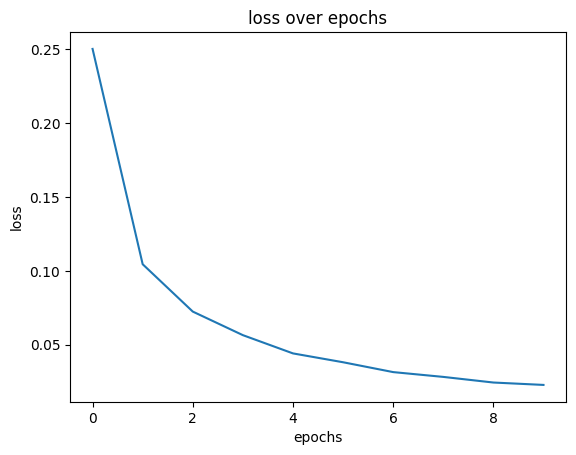

Accuracy on test set: 97.79%


In [6]:
config = parse_config('config/config1.json', VALID_JSON)
learning(config)

### Test 2
Use more deeper structure with decrise inputs cnt

Epoch 1 finished with avg loss: 0.2225
Epoch 2 finished with avg loss: 0.0939
Epoch 3 finished with avg loss: 0.0665
Epoch 4 finished with avg loss: 0.0520
Epoch 5 finished with avg loss: 0.0412
Epoch 6 finished with avg loss: 0.0379
Epoch 7 finished with avg loss: 0.0312
Epoch 8 finished with avg loss: 0.0267
Epoch 9 finished with avg loss: 0.0224
Epoch 10 finished with avg loss: 0.0249
[0.2225421  0.09394973 0.06648176 0.05201921 0.04118606 0.03793387
 0.03122166 0.02674546 0.0223842  0.02488709]


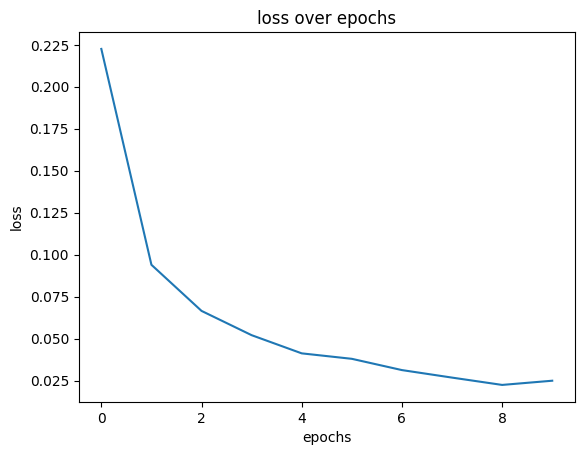

Accuracy on test set: 97.94%


In [7]:
config = parse_config('config/config2.json', VALID_JSON)
learning(config)

### Test 3
Activation function is sig

Epoch 1 finished with avg loss: 0.2409
Epoch 2 finished with avg loss: 0.0976
Epoch 3 finished with avg loss: 0.0679
Epoch 4 finished with avg loss: 0.0517
Epoch 5 finished with avg loss: 0.0408
Epoch 6 finished with avg loss: 0.0348
Epoch 7 finished with avg loss: 0.0301
Epoch 8 finished with avg loss: 0.0266
Epoch 9 finished with avg loss: 0.0212
Epoch 10 finished with avg loss: 0.0181
[0.24094873 0.09763285 0.06786909 0.05172008 0.0407881  0.03479329
 0.03010995 0.0265876  0.02121108 0.01810566]


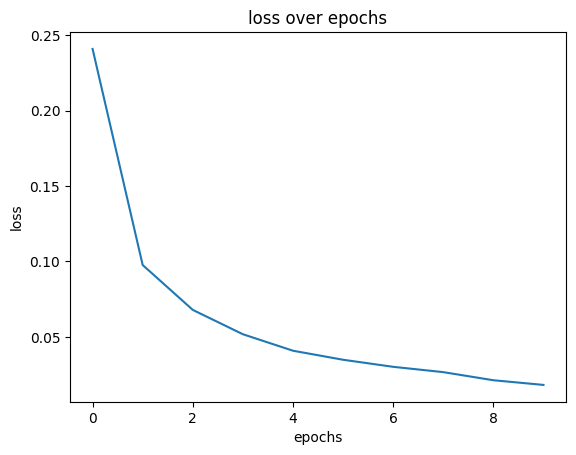

Accuracy on test set: 97.91%


In [8]:
config = parse_config('config/config3.json', VALID_JSON)
learning(config)

### Test 4
Activation function is identity

Epoch 1 finished with avg loss: 0.3813
Epoch 2 finished with avg loss: 0.3200
Epoch 3 finished with avg loss: 0.3107
Epoch 4 finished with avg loss: 0.3020
Epoch 5 finished with avg loss: 0.2973
Epoch 6 finished with avg loss: 0.2928
Epoch 7 finished with avg loss: 0.2894
Epoch 8 finished with avg loss: 0.2868
Epoch 9 finished with avg loss: 0.2836
Epoch 10 finished with avg loss: 0.2831
[0.38126774 0.3200369  0.31066142 0.302035   0.29727934 0.29277389
 0.28944849 0.286811   0.28360875 0.28308013]


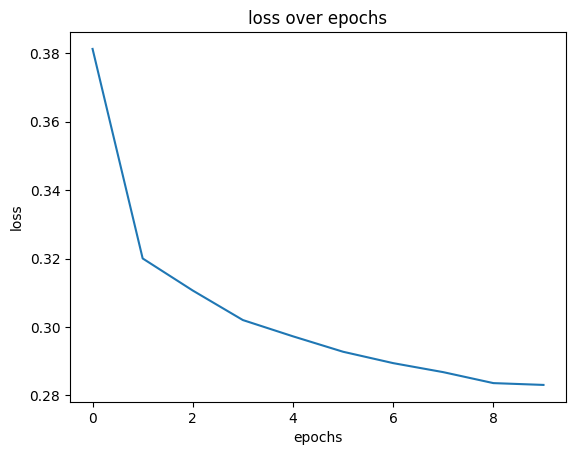

Accuracy on test set: 92.09%


In [9]:
config = parse_config('config/config4.json', VALID_JSON)
learning(config)

### Test 5
Use greater learning rate

Epoch 1 finished with avg loss: 0.2934
Epoch 2 finished with avg loss: 0.2069
Epoch 3 finished with avg loss: 0.1846
Epoch 4 finished with avg loss: 0.1638
Epoch 5 finished with avg loss: 0.1589
Epoch 6 finished with avg loss: 0.1577
Epoch 7 finished with avg loss: 0.1415
Epoch 8 finished with avg loss: 0.1435
Epoch 9 finished with avg loss: 0.1368
Epoch 10 finished with avg loss: 0.1368
[0.29335775 0.20689232 0.18461082 0.16384482 0.15888921 0.15774347
 0.14151583 0.14345599 0.13678362 0.13684137]


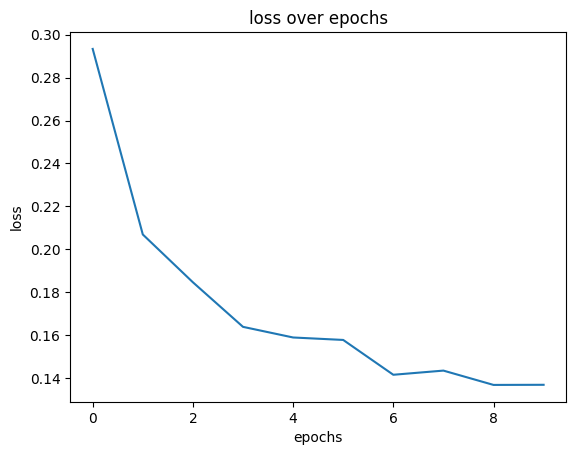

Accuracy on test set: 96.08%


In [10]:
config = parse_config('config/config5.json', VALID_JSON)
learning(config)

### Test 6
Use smaller learning rate

Epoch 1 finished with avg loss: 0.5982
Epoch 2 finished with avg loss: 0.2619
Epoch 3 finished with avg loss: 0.2093
Epoch 4 finished with avg loss: 0.1757
Epoch 5 finished with avg loss: 0.1506
Epoch 6 finished with avg loss: 0.1315
Epoch 7 finished with avg loss: 0.1167
Epoch 8 finished with avg loss: 0.1033
Epoch 9 finished with avg loss: 0.0925
Epoch 10 finished with avg loss: 0.0839
[0.59816809 0.26189144 0.20928119 0.17567943 0.15060743 0.13154904
 0.11670096 0.10330351 0.09248553 0.0838676 ]


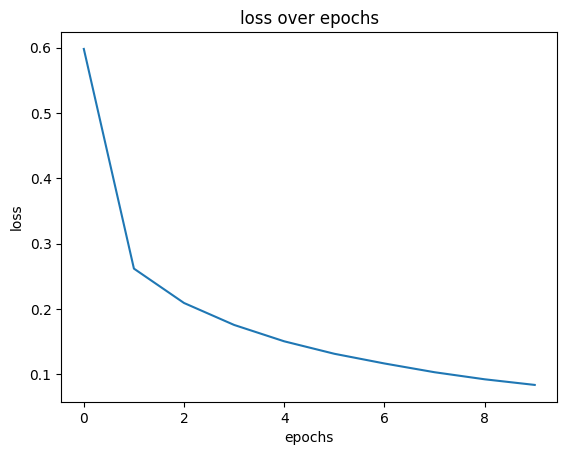

Accuracy on test set: 97.16%


In [11]:
config = parse_config('config/config6.json', VALID_JSON)
learning(config)

### Test 7
Use smaller batches

Epoch 1 finished with avg loss: 0.2326
Epoch 2 finished with avg loss: 0.1045
Epoch 3 finished with avg loss: 0.0727
Epoch 4 finished with avg loss: 0.0583
Epoch 5 finished with avg loss: 0.0463
Epoch 6 finished with avg loss: 0.0396
Epoch 7 finished with avg loss: 0.0373
Epoch 8 finished with avg loss: 0.0324
Epoch 9 finished with avg loss: 0.0275
Epoch 10 finished with avg loss: 0.0255
[0.23258742 0.10448869 0.07273604 0.058255   0.04631004 0.03964106
 0.03728505 0.03235579 0.02754867 0.02545433]


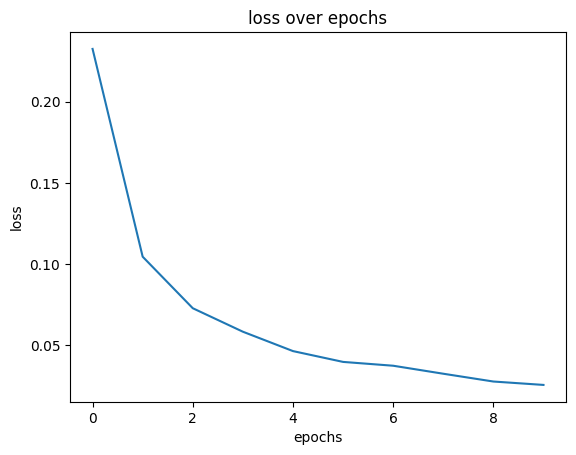

Accuracy on test set: 97.47%


In [12]:
config = parse_config('config/config7.json', VALID_JSON)
learning(config)

### Test 8
Use greater batches

Epoch 1 finished with avg loss: 0.3051
Epoch 2 finished with avg loss: 0.1242
Epoch 3 finished with avg loss: 0.0834
Epoch 4 finished with avg loss: 0.0636
Epoch 5 finished with avg loss: 0.0505
Epoch 6 finished with avg loss: 0.0387
Epoch 7 finished with avg loss: 0.0359
Epoch 8 finished with avg loss: 0.0247
Epoch 9 finished with avg loss: 0.0234
Epoch 10 finished with avg loss: 0.0214
[0.30508698 0.12415221 0.08337163 0.06360102 0.05054282 0.03867335
 0.03593509 0.02470702 0.02344368 0.02143554]


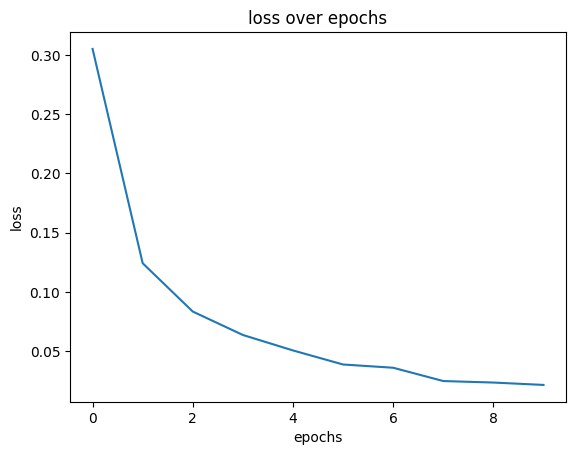

Accuracy on test set: 97.64%


In [13]:
config = parse_config('config/config8.json', VALID_JSON)
learning(config)

### Test 9
Use more epochs

In [14]:
#config = parse_config('config/config9.json', VALID_JSON)
#learning(config)
# need time